In [735]:
from matplotlib import pyplot as plt
from pylab import *
import numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
import cmath
sys.path.insert(0, '/Users/haly/idefix/pytools')
from vtk_io import *
pi = 3.14159






In [860]:
# Some useful functions

def calculate_KE(directory,snapshot,Nx,Nz):
    file    = directory + "/data."+ "{:04d}".format(snapshot) + ".vtk"
    d = readVTK(file, geometry='cartesian')
    rho_g = d.data.get("RHO")
    vz_g = d.data.get("VX3")
    rho_g = rho_g.reshape(Nx,Nz)
    vz_g = vz_g.reshape(Nx,Nz)

    return (0.5*1.2/Nz*1/Nx*pi*np.sum(rho_g*vz_g*vz_g))

def calculate_growth_rate(kx,n,w,psi,ts,f):
    Lz = 1
    kb = 2.*pi/Lz
    C1 = (kx*(2*w+1)*((w+1)**2*w**2-kb**2*(n+1)*(n+w**2)))/(8*w*(w**2-n*kb)*(w**2+n*kb))
    C2 = (-kx*(2*w+1)*(w**2*(1+w)**2+n*kb**2*w*(2+w)-n**2*kb**2))/(8*(1+w)*((1+w)**2-(n+1)*kb)*((1+w)**2+(n+1)*kb))
    D1 = ((w**2-1)*(-n**2*ts*kb**2*(1j+2*ts*w)+(1j+ts*w)*w**2*(ts+1j*w+ts*w**2)))/(2*(1j+ts*(w-1))*(1j+ts*w)*(1j+ts+ts*w)*(w**4-n**2*kb**2))
    D2 = (-w*(2+w)*((1+w)**3-ts**2*(1+w)*(-2*(1+n)**2*kb**2+(1+w)**2*(2+w*(2+w)))+1j*ts*((1+n)**2*kb**2-(1+w)**2*(3+2*w*(2+w)))))/(2*(1j+ts*w)*(1j+ts+ts*w)*((1+w)**2-(1+n)*kb)*((1+w)**2+(1+n)*kb)*(1j+ts*(2+w)))
    S1 = (-f*(D1+D2)+cmath.sqrt(f**2*(D1**2+D2**2-2*D1*D2)+4*psi**2*C1*C2))/2
    S2 = (-f*(D1+D2)-cmath.sqrt(f**2*(D1**2+D2**2-2*D1*D2)+4*psi**2*C1*C2))/2
    return max(np.real(S1), np.real(S2))

def calculate_numerical_growth_rate(directory):
    time, dens_dust, vKE = read_history(directory+"/timevol.dat")
    time = np.multiply(time,1./2./pi)
    KE_for_fit = vKE[0:301]
    time_for_fit = time[0:301]
    slope, intercept, r, p, se = sp.stats.linregress(time_for_fit, log(KE_for_fit))
    return slope/2/pi/2


def calculate_dust_eigenmodes(kx,n,w,ts):
    Lz = 1
    kb = 2.*pi/Lz
    pert=0.0001

    ug = 1j*w*(w**2-kb**2*n**2)
    vg = 0.5*(w**2-kb**2*n**2)
    wg = 1j*kx*kb*n*w
    chi = -(1j+ts*(w+1))/(1j+ts*(w-1))

    ud = (ug+2*ts*vg-1j*ts*ug*w)/chi
    vd = (-2*vg+ts*(ug+2j*vg*w))/(-2*chi)
    wd = (1j*wg)/(1j+ts*w)
    hd = (1j/w)*((kb*n*wg)/(1j+ts*w)-(kx*(1j*(ug+2*ts*vg)+ts*ug*w))/(chi))
    tex1 = f'cos(Kx*x+Kb*{n}*z)'
    tex2 = f'sin(Kx*x+Kb*{n}*z)'
    norm = pert/ud
    #norm_imag = pert/np.imag(ud)/sqrt(2)

    print(f"rho_d *= exp({np.real(norm*hd):.8f}*{tex1}-{np.imag(norm*hd):.8f}*{tex2});")
    print(f"ud += {np.real(norm*ud):.8f}*{tex1}-{np.imag(norm*ud):.8f}*{tex2};")
    print(f"vd += {np.real(norm*vd):.8f}*{tex1}-{np.imag(norm*vd):.8f}*{tex2};")
    print(f"wd += {np.real(norm*wg):.8f}*{tex1}-{np.imag(norm*wg):.8f}*{tex2};")


def read_history(directory):
    f = open(directory, 'r')
    time =  []
    rho_max = []
    vKE = []

    for line in f:
        line = line.strip()
        columns = line.split()
        time.append(float(columns[0])) 
        rho_max.append(float(columns[1]))
        vKE.append(float(columns[2]))
    f.close()
    return time, rho_max, vKE
  


In [896]:
calculate_dust_eigenmodes(kx=15.6,n=2,w=1-0.373,ts=0.1)

rho_d *= exp(0.00493997*cos(Kx*x+Kb*2*z)-0.00020321*sin(Kx*x+Kb*2*z));
ud += 0.00010000*cos(Kx*x+Kb*2*z)-0.00000000*sin(Kx*x+Kb*2*z);
vd += 0.00000736*cos(Kx*x+Kb*2*z)--0.00007811*sin(Kx*x+Kb*2*z);
wd += 0.00012298*cos(Kx*x+Kb*2*z)-0.00000247*sin(Kx*x+Kb*2*z);


In [825]:
print(calculate_growth_rate(kx=15.6,n=1,w=-0.373,psi=0.01,ts=10,f=0.1))


0.00026769951110572864


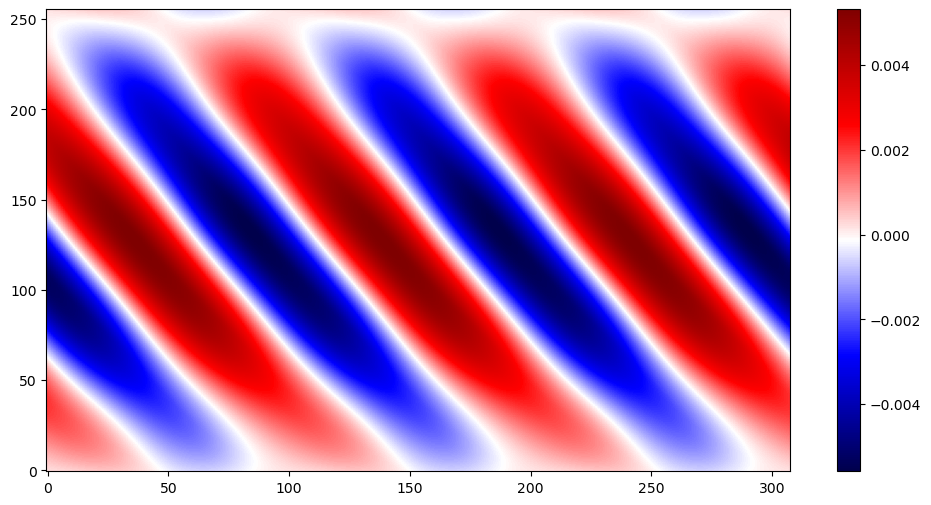

In [920]:
# Read and plot gas

plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1,1)

#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/gas/run_256"
directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_0.1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.27/run"

snapshot = 2
Nx = 308
Nz= 256


file = directory + f"/data.{snapshot:04d}.vtk"
d = readVTK(file, geometry='cartesian')
rho_g = d.data.get("RHO")
vx_g = d.data.get("VX1")
vy_g = d.data.get("VX2")
vz_g = d.data.get("VX3")
rho_g = rho_g.reshape(Nx,Nz)
vx_g = vx_g.reshape(Nx,Nz)
vy_g = vy_g.reshape(Nx,Nz)
vz_g = vz_g.reshape(Nx,Nz)

im = axs.imshow(vz_g.T,origin='lower',norm="linear",cmap="seismic", aspect='auto')
fig.colorbar(im)


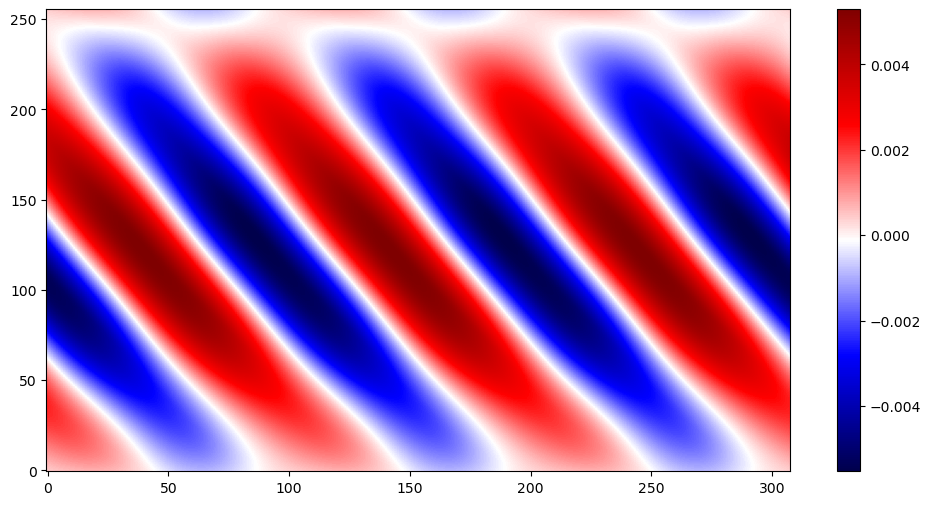

In [922]:
# Read and plot dust

plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1,1)

#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust_pert_gas_only/run"
directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_0.1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.03/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.09/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.27/run"

snapshot = 2
Nx = 308
Nz= 256


file = directory + f"/data.{snapshot:04d}.vtk"
d = readVTK(file, geometry='cartesian')
rho_d = d.data.get("Dust0_RHO")
vx_d = d.data.get("Dust0_VX1")
vy_d = d.data.get("Dust0_VX2")
vz_d = d.data.get("Dust0_VX3")
rho_d = rho_d.reshape(Nx,Nz)
vx_d = vx_d.reshape(Nx,Nz)
vy_d = vy_d.reshape(Nx,Nz)
vz_d = vz_d.reshape(Nx,Nz)

im = axs.imshow(vz_d.T,origin='lower',norm="linear",cmap="seismic", aspect='auto')
fig.colorbar(im)

Text(0.5, 1.0, '$\\tau_s=1$, $f=0.01$')

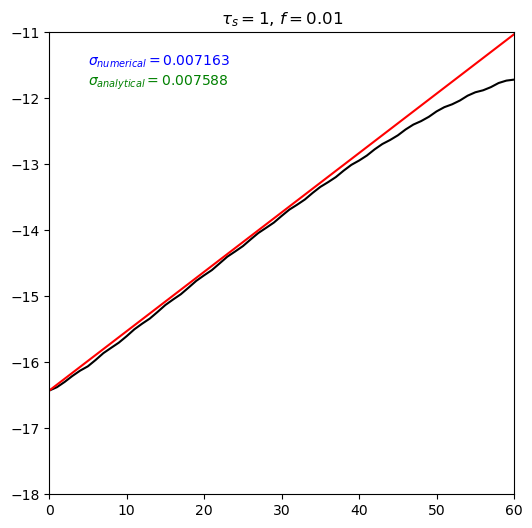

In [ ]:
# calculate numerical and analytical growth rates from snapshots (like a pleb!)

plt.rcParams["figure.figsize"] = (6,6)
fig, axs = plt.subplots(1,1)

directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust_pert_gas_only/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/gas/run_256"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.05/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.04/run"

Nx = 308
Nz= 256
f = 0.01

time= linspace(0,61,num=62)
KE = zeros_like(time)
for i in range(0,len(KE)):
    KE[i]=calculate_KE(directory,i,Nx,Nz)
KE_for_fit = KE[0:31]
time_for_fit = time[0:31]


slope, intercept, r, p, se = sp.stats.linregress(time_for_fit, log(KE_for_fit))
axs.plot(time, log(KE),color='black')
axs.axline((time[0],log(KE[0])),slope=slope,color='red')
axs.set_xlim(0,60)
axs.set_ylim(-18,-11)
axs.text(5,-11.5,r'$\sigma_{numerical}=$'+"{:06f}".format(slope/2./pi/2.), color="blue")
axs.text(5,-11.8,r'$\sigma_{analytical}=$'+"{:06f}".format(calculate_growth_rate(kx=15.6,n=1,w=-0.373,psi=0.01,ts=1,f=f)), color="green")
axs.set_title(fr'$\tau_s=1$, $f={f}$')

Text(0.5, 1.0, '$\\tau_s=0.1$, $f=0.01$')

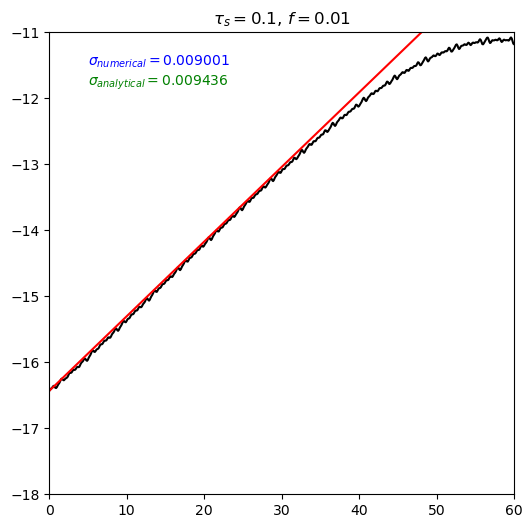

In [918]:
# calculate numerical and analytical growth rates from log tables (like a pro!)

plt.rcParams["figure.figsize"] = (6,6)
fig, axs = plt.subplots(1,1)

#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/tests/test_dust_pert_gas_only/run"
directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_0.1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.01/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.03/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.09/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.27/run"
#directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_1_f_0.81/run"


Nx = 308
Nz= 256
f = 0.01
ts = 0.1

time, dens_dust, vKE = read_history(directory+"/timevol.dat")
time = np.multiply(time,1./2./pi)
KE_for_fit = vKE[0:301]
time_for_fit = time[0:301]
slope, intercept, r, p, se = sp.stats.linregress(time_for_fit, log(KE_for_fit))

axs.plot(time, log(vKE),color='black')
axs.axline((time[0],log(vKE[0])),slope=slope,color='red')
axs.set_xlim(0,60)
axs.set_ylim(-18,-11)
axs.text(5,-11.5,r'$\sigma_{numerical}=$'+"{:06f}".format(slope/2./pi/2.), color="blue")
axs.text(5,-11.8,r'$\sigma_{analytical}=$'+"{:06f}".format(calculate_growth_rate(kx=15.6,n=1,w=-0.373,psi=0.01,ts=ts,f=f)), color="green")
axs.set_title(fr'$\tau_s={ts}$, $f={f}$')

In [917]:
# Produce growth rate tables for a grid of simulations
directory = "/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing"
print(r"ts.     $\Beta$.     $\sigma_{th}$      $\sigma_{num}$")
for ts in [0.1, 1, 10]:
    for f in [0.01, 0.03, 0.09, 0.27, 0.81]:      
        file = directory+f"/st_{ts}_f_{f}/run"
        num = calculate_numerical_growth_rate(file)
        print(f'{ts}     {f/0.01}     {calculate_growth_rate(kx=15.6,n=1,w=-0.373,psi=0.01,ts=ts,f=f)}    {num}')

ts.     $\Beta$.     $\sigma_{th}$      $\sigma_{num}$
0.1     1.0     0.009435578804834574    0.009000961595172328
0.1     3.0     0.008711687071221918    0.001411580825229869


FileNotFoundError: [Errno 2] No such file or directory: '/Users/haly/science/projects/local_dusty_warp_git/setups/free_sloshing/st_0.1_f_0.09/run/timevol.dat'